# Hospitals-Residents MIP
[![hospitals_residents.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/miscellaneous/hospitals_residents.ipynb)](https://colab.ampl.com)

Description: hospitals-residents problem with ties problem solved with ampl and highs

Tags: amplpy, assignment, mip, data-structures, graphs

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

Model author: N/A

References:
* Delorme, M., García, S., Gondzio, J., Kalcsics, J., Manlove, D., & Pettersson, W. (2019). *Mathematical models for stable matching problems with ties and incomplete lists*. European Journal of Operational Research, 277(2), 426-441.

* Manlove, D. F., Irving, R. W., Iwama, K., Miyazaki, S., & Morita, Y. (2002). *Hard variants of stable marriage*. Theoretical Computer Science, 276(1-2), 261-279.


In [1]:
# Install dependencies
%pip install -q amplpy==0.15.0b2 matplotlib networkx

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Description

The assignment problem is one of the most relevant problems in Operations Research. The Hospitals-Residents Problem (HR) and its variants is a particular case of the assignment problem, that focuses on the lists of preferences of the agents involved in the problem, and finding a **stable matching** between the agents.

In the HR Problem there are two different sets of agents: residents, who are applying to hospitals, and the hospitals which have to decide which residents to accept, and this decision is not arbitrary, each resident has a **ranked list** of the hospitals he prefers the most, and each hospital has a ranked list of the residents they like the most. The problem consists in finding a stable matching that is fair, in the sense that any resident and hospital that are not paired, would not prefer to be paired to each other.

It is a one-to-many assignment, as each hospital $j$ is assumed to have a **quote** of $Q_j$ residents, so it can match simultaneously to $Q_j$ residents, while each resident is matching one hospital at most.


## Variants and complexity

The case where each hospital has $q_j=1$ is called the Stable Marriage Problem (D. Gale and L. S. Shapley, 1962), that is a one-to-one assignment problem with lists of preferences. If the lists do not contain ties, there exist greedy algorithms to solve the problem by finding the matching (Gale-Shapley algorithm).

When there are ties (a resident ranks in the same position more than one hospital, or a hospital ranks the same more than one resident), the problem is called Hospitals-Residents Problem with Ties (HRT), and in that case, the matching is not necessarily unique. Finding the maximum size matching in a HRT instance is called MAX-HRT, and is NP-hard (Manlove et al., 2002).

There are still extensions to the Gale-Shapley algorithm to find stable matchings within an instance, but not necessarily maximal.

In this notebook we are presenting a Mixed-Integer Programming solution for the HRT problem implemented by using AMPL.


## MIP model

First we should formalize the notion of stable matching. If $r$ is a resident and $h$ a hospital, then $(r,h)$ will be an *acceptable pair* if $r$ is ranked by $h$ and viceversa (so it would make sense to assign $r$ to the hospital $h$).

We could think about a matching within the bipartite graph between the residents and the hospitals, as the subset of edges in the graph that determine the assignment. Then, a *blocking pair* $(r, h)$ is an acceptable pair within that matching that satisfies any of the following conditions:

* $r$ and $h$ are not paired in the match, and $h$ has been assigned to less than $q_j$ residents (so they could be paired to make the matching more stable).
* $r$ is not paired or it is paired to a hospital $h'$ worse ranked than $h$ inside the list of hospitals of $r$; and there exists $r'$ assigned to $h$ such that $r'$ is worse ranked than $r$ within the list of residents of $h$. In that case, it would be better to match $r$ and $h$ instead.
* $h$ is not full or exists a resident $r'$ worse ranked than $r$ by $h$ list; and the pair of $r$ in the matching is worse wanked than $h$ by $r$. It would be better to match $r$ and $h$ instead.

With this definition, a stable matching is a matching that does not contain any blocking pair.



* Sets:
    * `R`: set of residents
    * `H`: set of hospitals
* Parameters:
    * `Q {H}`: capacity/quote of the hospital

In order to simplify the notation, we assume that lists of preferences are a matrices where the preference of each hospital/resident is ranked by their position in the list. For example, if Rose is applying to 3 hospitals and her preferences are:
```
[H2, {H1, H3}]
```
meaning that her favourite hospital is H2, and she ranks the same H1 and H3. In this case, Rose's list of preference would be:
```
H1 H2 H3
2  1  2
```
And consequently the notation will be `prefR{Rose,H1} = 2`, `prefR{Rose,H2} = 1`, and `prefR{Rose,H3} = 2`, so the lower the preference the better ranked.

* (more) Parameters:
    * `prefR {R,H}`: resident's lists of preferences ranking hospitals
    * `prefH {H,R}`: hospital's lists of preferences ranking residents

In order to model the stability we are going to introduce more sets that will be used in the model

* set `lesseq_H{H,R}` := set of hospitals that rank as good or better than $h$ for resident $r$ ($h$ always belongs to this set). In AMPL this set could be defined as:
```
{hh in H : prefR[r,hh] <= prefR[r,h]};
```

* set `lesseq_R{R,H}` := set of residents that rank as good or better than $r$ for hospital $h$ ($r$ always belongs to this set).
```
{rr in R : prefH[h,rr] <= prefH[h,r]}
```

* Variables:
    * `x {R,H}`: binary variables, 1 if $r$ and $h$ are paired in the matching, 0 otherwise.

* Objective: maximize size of the matching:

$$\max \sum \limits_{(r, h) \in R \times H} x[r,h]$$

* Constraints:

Each resident $r$ is matched to 1 hospital or is not matched:

$$\sum \limits_{h \in H}  x[r,h] \leq 1$$

Each hospital $h$ does not allow more residents than its quote:

$$\sum \limits_{r \in R}  x[r,h] \leq Q[j]$$

Stability conditions to ensure that there are no blocking pairs in the matching. For each acceptable pair $(r,h)$:

$$Q[h] \sum \limits_{h' \in lesseq\_H\{H,R\}} x[r,h'] + \sum \limits_{r' \in lesseq\_R\{R,H\}} x[r',h] \geq Q[h]$$

If $r$ and $h$ are paired, the constraint is satisfied trivially. They are a blocking pair if and only if the first sum is going to be zero (so $r$ could have been matched to $h$) and the second must be less than $Q_j$ (so $h$ has enough quote to match with $r$). Otherwise the first sum must be 1 so $r$ is matched with a better hospital and the pair would be not blocking, or the first sum is $Q_j$ so $h$ is matched with $Q_j$ better residents than $r$. Notice that there is a **quadratic number of stability constraints**, and might be hard to deal with them. There are MIP formulations that try to solve this inconvenient.

*Note*: in AMPL we set the default preference to -1, in order to determine the acceptable pairs that should not be computed in the sum, as the variables $x$ make sense only if the resident and the hospital are an acceptable pair.

In [3]:
%%writefile hrt.mod

### Sets and params ###

# Hospitals
set H;
# Residents
set R;

# Preferences
# h's rank of residents
param prefH{H,R} default -1;
# r's rank of hospitals
param prefR{R,H} default -1;
# Capacity of the hospitals
param Q{H} default 1;

### Variables ###

# Assignments
var x{R,H} binary;

# An acceptable pair is (r,h) such that prefR[r,h] >= 0 and prefH[h,r] >= 0

### Objective ###
maximize Matching_Size : sum{r in R, h in H : prefH[h,r] >= 0 and prefR[r,h] >= 0} x[r,h];

### Constraints ###
doc_assign{r in R}:
	sum{h in H : prefH[h,r] >= 0 and prefR[r,h] >= 0} x[r,h] <= 1;

hos_assign{h in H}:
	sum{r in R : prefR[r,h] >= 0 and prefH[h,r] >= 0} x[r,h] <= Q[h];

### Stability constraints
stability{r in R, h in H : prefH[h,r] >= 0 and prefR[r,h] >= 0}:
	Q[h]*sum{hh in H : prefR[r,hh] <= prefR[r,h] and prefR[r,hh] >= 0 and prefH[hh,r] >= 0} x[r,hh] + sum{rr in R : prefH[h,rr] <= prefH[h,r] and prefR[rr,h] >= 0 and prefH[h,rr] >= 0} x[rr,h] >= Q[h];

### Special sets reminder ###
# Hospitals better than h for resident r
# set lesseq_H{H,R} := {hh in H : prefR[r,hh] <= prefR[r,h]};

# Residents better than r for hospital h
# set lesseq_R{R,H} := {rr in R : prefH[h,rr] <= prefH[h,r]};

# Set to zero non-acceptable pairs
non_acceptable {r in R, h in H : prefH[h,r] < 0 or prefR[r,h] < 0}:
	x[r,h] = 0;


Overwriting hrt.mod


In [4]:
%%writefile hrt.dat
data;

set H := "Porto Hosp", "Madrid 12 Oct", "Hosp. East Boston", "Melbourne Medical Center";
set R := "Christian", "Meg", "Nicolau", "Gleb", "Bob", "Martin", "Melinh";

param prefH := 
"Porto Hosp" "Christian" 1
"Porto Hosp" "Meg" 1
"Porto Hosp" "Nicolau" 2
"Porto Hosp" "Bob" 2
"Porto Hosp" "Gleb" 3
"Porto Hosp" "Martin" 4

"Madrid 12 Oct" "Christian" 1
"Madrid 12 Oct" "Meg" 1
"Madrid 12 Oct" "Melinh" 2
"Madrid 12 Oct" "Nicolau" 3
"Madrid 12 Oct" "Gleb" 4

"Hosp. East Boston" "Christian" 1
"Hosp. East Boston" "Bob" 1
"Hosp. East Boston" "Meg" 2
"Hosp. East Boston" "Melinh" 3
"Hosp. East Boston" "Nicolau" 4
"Hosp. East Boston" "Gleb" 4
"Hosp. East Boston" "Martin" 4

"Melbourne Medical Center" "Nicolau" 1
"Melbourne Medical Center" "Gleb" 1
"Melbourne Medical Center" "Christian" 2
"Melbourne Medical Center" "Meg" 3
"Melbourne Medical Center" "Bob" 3
"Melbourne Medical Center" "Melinh" 4
;

param prefR := 
"Christian" "Porto Hosp" 1
"Christian" "Madrid 12 Oct" 2
"Christian" "Hosp. East Boston" 3
"Christian" "Melbourne Medical Center" 3

"Meg" "Porto Hosp" 1
"Meg" "Madrid 12 Oct" 2
"Meg" "Hosp. East Boston" 2
"Meg" "Melbourne Medical Center" 2

"Nicolau" "Porto Hosp" 1
"Nicolau" "Madrid 12 Oct" 1
"Nicolau" "Hosp. East Boston" 2
"Nicolau" "Melbourne Medical Center" 2

"Gleb" "Madrid 12 Oct" 1
"Gleb" "Porto Hosp" 2
"Gleb" "Hosp. East Boston" 2
"Gleb" "Melbourne Medical Center" 3

"Bob" "Porto Hosp" 1
"Bob" "Hosp. East Boston" 2
"Bob" "Melbourne Medical Center" 3

"Martin" "Hosp. East Boston" 1
"Martin" "Porto Hosp" 2

"Melinh" "Melbourne Medical Center" 1
;

# Capacities

param Q :=
"Porto Hosp" 2
"Madrid 12 Oct" 2
"Hosp. East Boston" 2
"Melbourne Medical Center" 1
;


Overwriting hrt.dat


In [5]:
%%ampl_eval
reset;
model hrt.mod;
data hrt.dat;
option solver highs;
option presolve 0;
solve;
display x;
for {r in R}{
    for {h in H}{
        if x[r,h] = 1 then
            printf "%s is assigned to %s\n", r, h;
    }
}

HiGHS 1.2.2: HiGHS 1.2.2: optimal solution; objective 7
0 branching nodes
x [*,*]
# $3 = 'Melbourne Medical Center'
:         'Hosp. East Boston' 'Madrid 12 Oct'  $3 'Porto Hosp'    :=
Bob                 1                 0         0       0
Christian           0                 0         0       1
Gleb                0                 1         0       0
Martin              1                 0         0       0
Meg                 0                 0         0       1
Melinh              0                 0         1       0
Nicolau             0                 1         0       0
;

Christian is assigned to Porto Hosp
Meg is assigned to Porto Hosp
Nicolau is assigned to Madrid 12 Oct
Gleb is assigned to Madrid 12 Oct
Bob is assigned to Hosp. East Boston
Martin is assigned to Hosp. East Boston
Melinh is assigned to Melbourne Medical Center


### Solution

Finally show the matching by using the AMPL API and the Networkx library

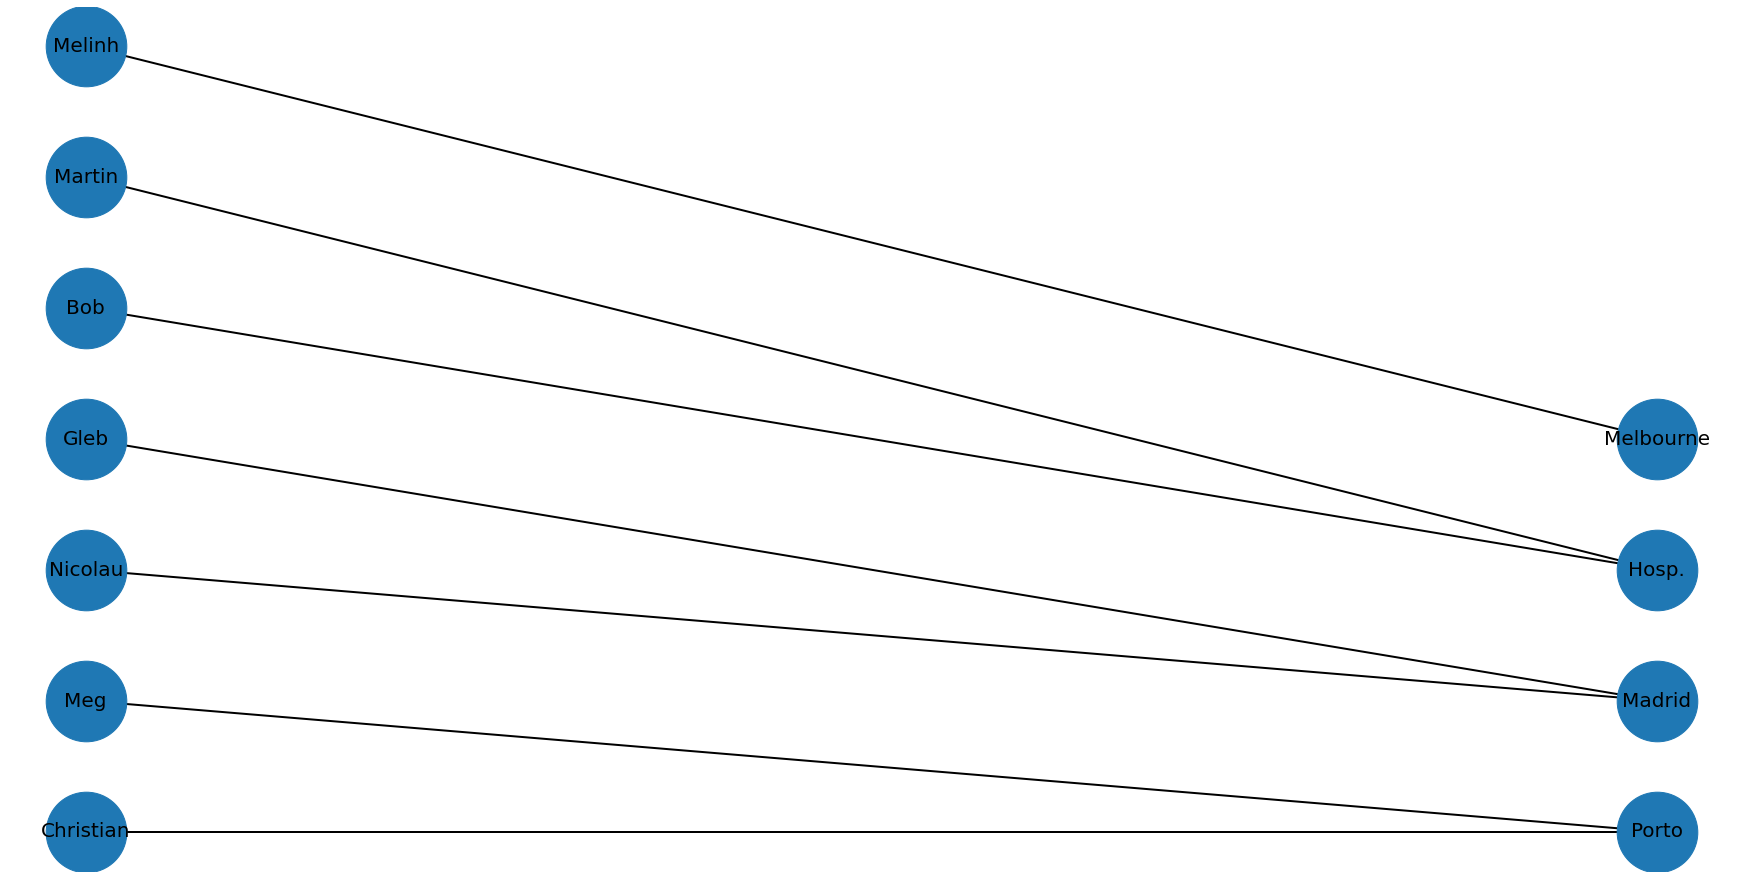

In [6]:
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt

# Retrieve data from AMPL
R = ampl.get_data("R").to_list()
H = ampl.get_data("H").to_list()
H_short = list(map(lambda s: s.split()[0], H))

# Build the graph with Networkx library
G = nx.Graph()
G.add_nodes_from(R, bipartite=0)
G.add_nodes_from(H_short, bipartite=1)

# Fill the edges (assigned pairs)
for r, h in product(R, H):
    if ampl.var["x"][r, h].value() == 1.0:
        G.add_edge(r, h.split()[0])

# Draw graph
plt.rcParams["figure.figsize"] = (24, 12)
pos = {}
pos.update((n, (0, i)) for i, n in enumerate(R))
pos.update((n, (1, i)) for i, n in enumerate(H_short))
nx.draw(G, pos=pos, font_size=20, with_labels=True, node_size=6500, width=2.0)
plt.show()